In [9]:
using StanSample, Distributions, Dates
using DataFrames, CSV
using CairoMakie

In [2]:
ENV["JULIA_CMDSTAN_HOME"] = expanduser("~/cmdstan");

In [3]:
include("../src/rt-from-frequency-dynamics.jl")
using .rt_from_frequency_dynamics

In [4]:
# Plot aes
colors_syn =  ["green", "hotpink"]
colors_variant = ["#2e5eaa", "#5adbff", "#f03a47", "#56e39f","#b4c5e4",  "#f5bb00", "#9e4244", "#808080"] 
alphas = [0.65, 0.45, 0.35]
ps = [0.5, 0.8, 0.95]

3-element Vector{Float64}:
 0.5
 0.8
 0.95

In [5]:
# Loading shared objects
g, onset = get_standard_delays()
seed_L = 7
forecast_L = 0

0

## Loading Synthetic Data

In [6]:
# Load data
synthetic_df = DataFrame(CSV.File("../data/processed/synthetic_data.csv"))
LD_syn = LineageData(synthetic_df)


# Create the rt_model
model_syn = SplineTrend(20,  length(LD_syn.cases), 4)
priors_syn = [["LAS"]]
LM_syn = FreeLineageModel(g, onset, model_syn, priors_syn, seed_L, forecast_L)
MS_syn = make_stan(LM_syn, LD_syn, "test_model", "../data/sims/test_interface/synth")
# Change path and re-run later

ModelStan(SampleModel("test_model", "\nfunctions {\n  int get_L_nonzero(int[] Z, int L){\n    int L_nonzero = 0;\n    for (i in 1:L){\n      if(Z[i] > 0){ \n        L_nonzero += 1;\n      }\n    }\n    return L_nonzero;\n  }\n\n  int[] get_nonzero_idx(int[] Z, int L_nonzero, int L){\n    int cur_idx = 1;\n    int non_zero_idx[L_nonzero];\n\n    for (i in 1:L){\n      if(Z[i] > 0){\n        non_zero_idx[cur_idx] = i;\n        cur_idx += 1;\n      }\n    }\n    return non_zero_idx;\n  }\n\n\n  matrix get_weekend_mat(int L){\n        matrix[L, 7] wk_mat = rep_matrix(0, L, 7);\n        for (i in 1:L){\n           wk_mat[i, (i % 7)+1] = 1;\n        }\n        return(wk_mat);\n    }\n\n  vector get_infections(vector R, real I0, vector g_rev, int T, int l, int seed_L){\n    vector[T] I;\n    I[1:seed_L] = rep_vector(I0, seed_L);\n\n    // Loop for dates without full backlog\n    for (t in seed_L:(l-1)){\n      I[t+1] = R[t-seed_L+1] * dot_product(I[1:t], tail(g_rev, t));\n    }\n    // Loop f

In [7]:
load_samples!(MS_syn)

8895-element Vector{String}:
 "b.1.1"
 "b.2.1"
 "b.3.1"
 "b.4.1"
 "b.5.1"
 "b.6.1"
 "b.7.1"
 "b.8.1"
 "b.9.1"
 "b.10.1"
 "b.11.1"
 "b.12.1"
 "b.13.1"
 ⋮
 "obs_freqs.389.2"
 "obs_freqs.390.2"
 "obs_freqs.391.2"
 "obs_freqs.392.2"
 "obs_freqs.393.2"
 "obs_freqs.394.2"
 "obs_freqs.395.2"
 "obs_freqs.396.2"
 "obs_freqs.397.2"
 "obs_freqs.398.2"
 "obs_freqs.399.2"
 "obs_freqs.400.2"

In [8]:
## Making figure 1
using CairoMakie



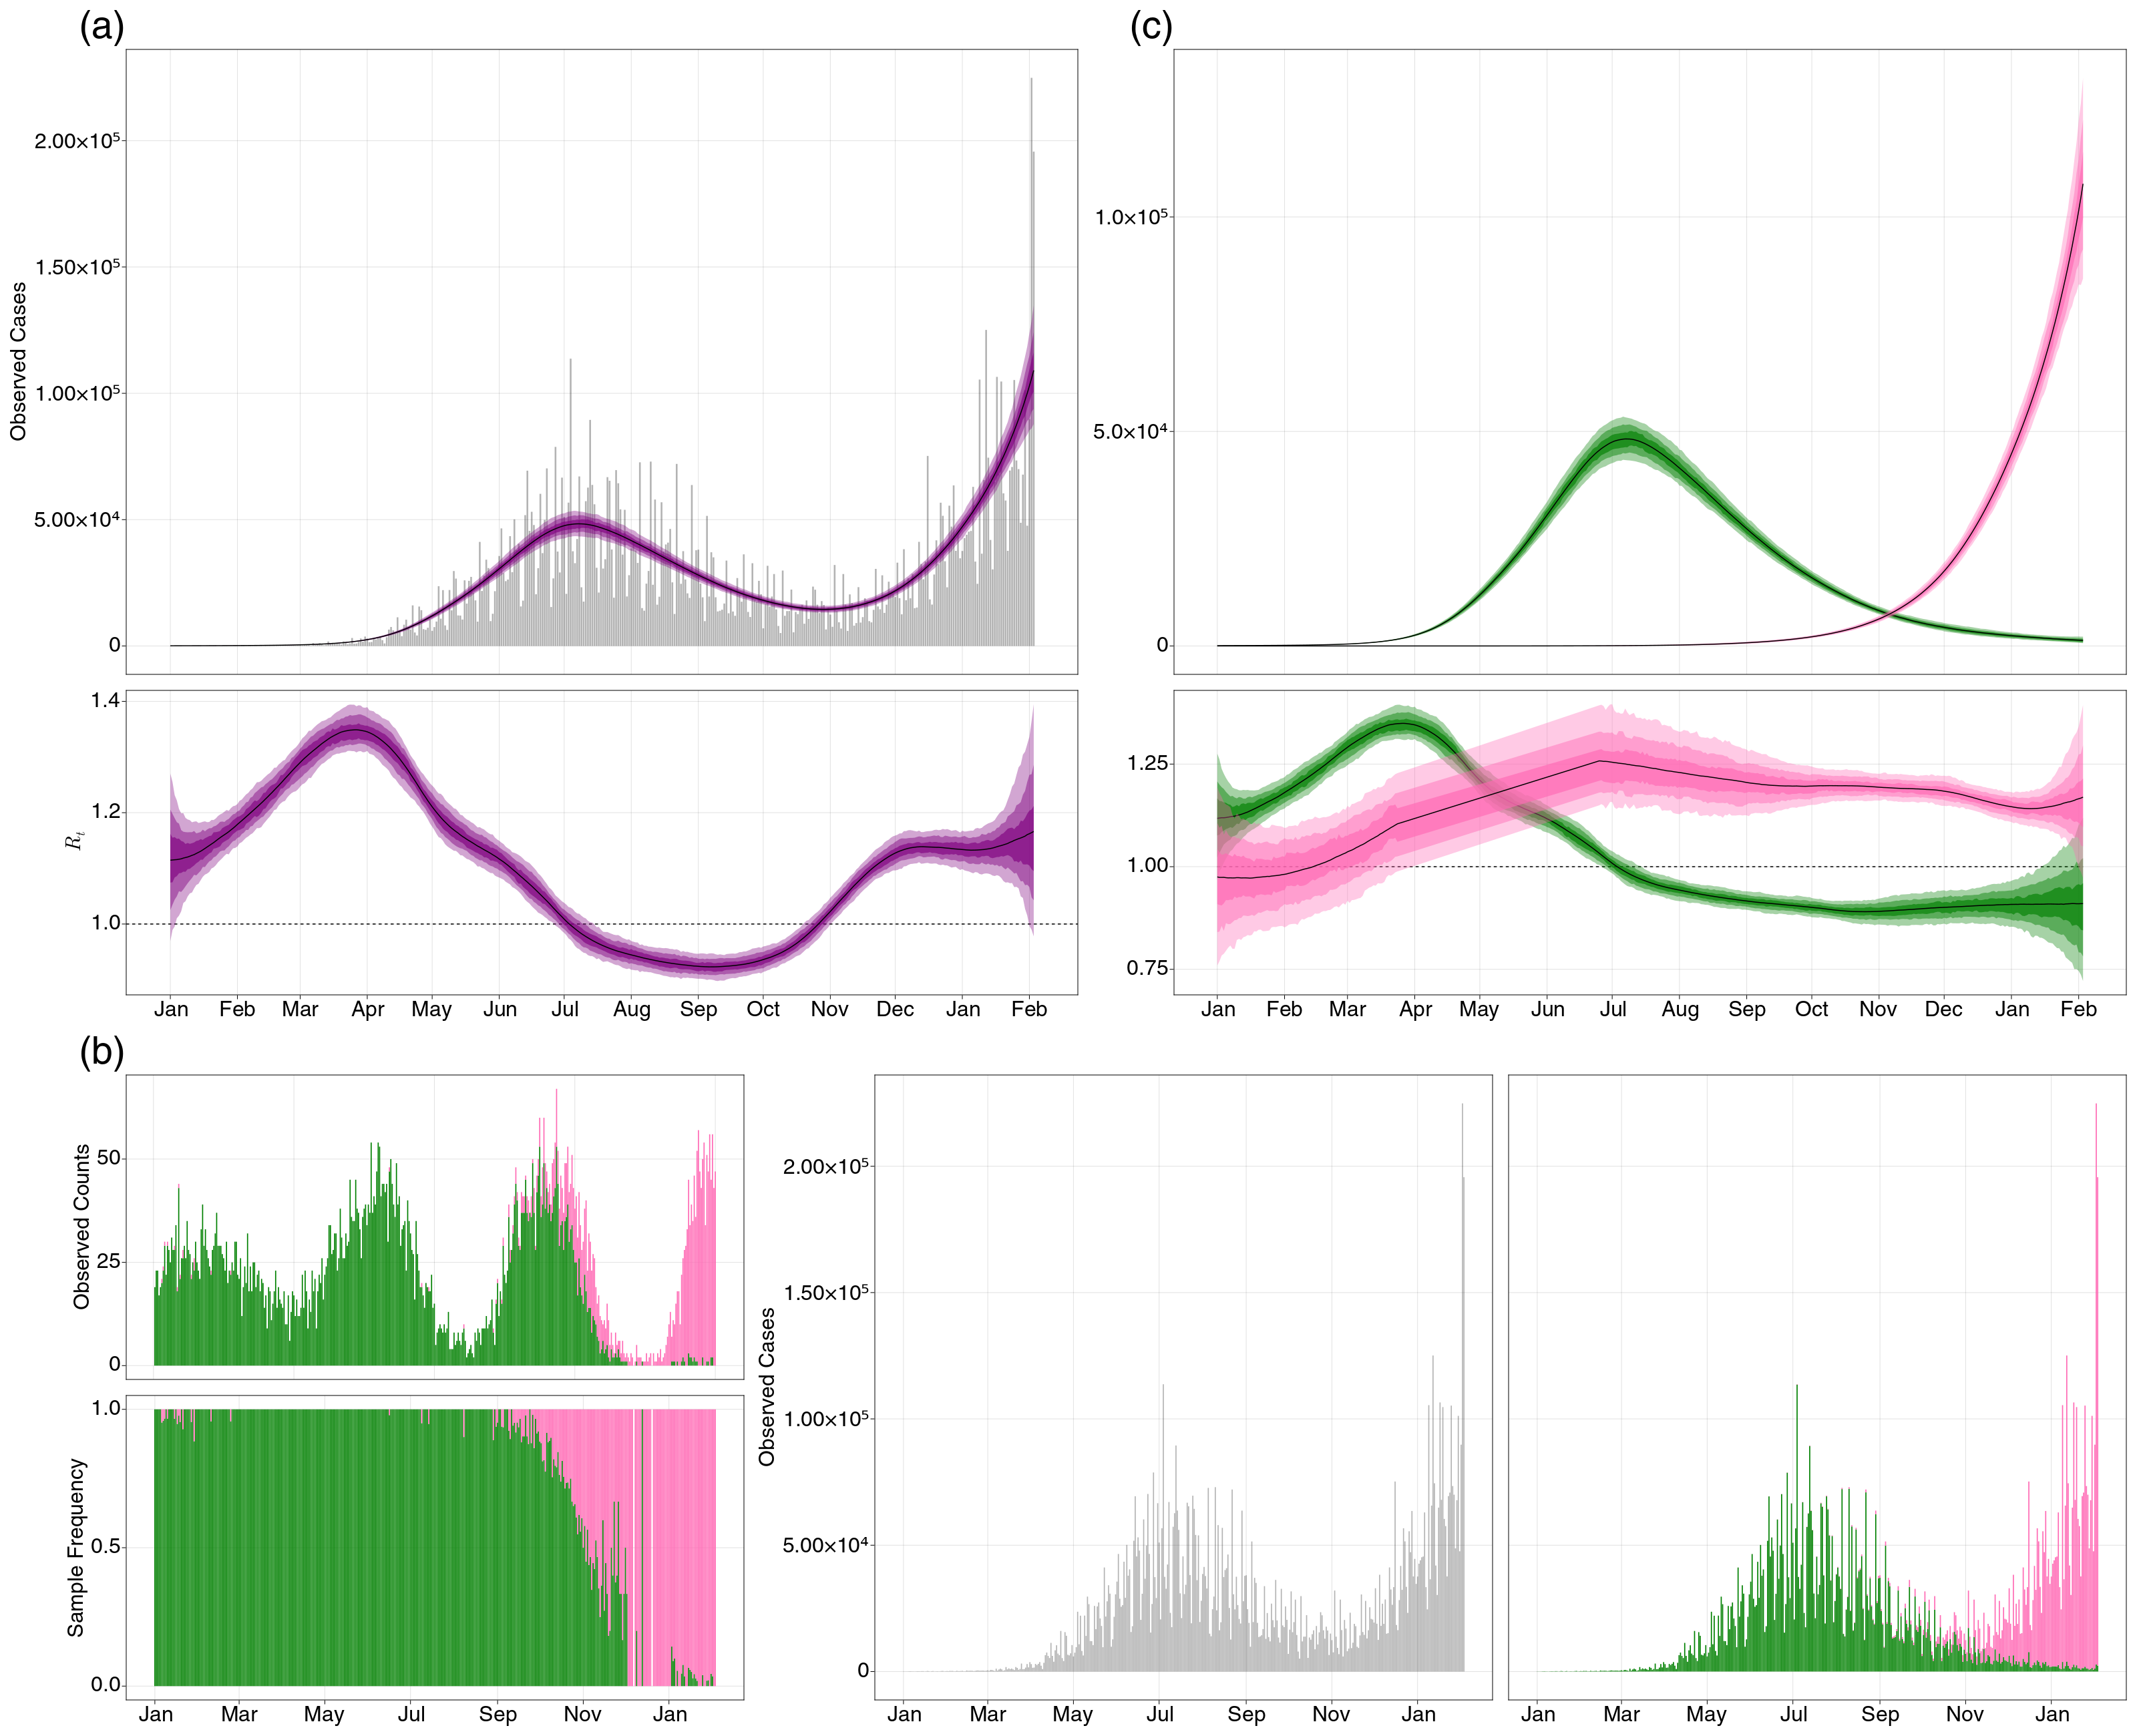

In [9]:
fig_1 = figure_1(MS_syn, LD_syn, colors_syn)

In [60]:
save("../manuscript/figs/fig_1.png", fig_1)

CairoScreen{Cairo.CairoSurfaceBase{UInt32}} with surface:
Cairo.CairoSurfaceBase{UInt32}(Ptr{Nothing} @0x00007f9a95f49380, 3200.0, 2600.0)


# Loading US states

In [26]:
cases_df = DataFrame(CSV.File("../data/location-case-counts.tsv"))
seq_df = DataFrame(CSV.File("../data/location-variant-sequence-counts.tsv"))

32918×4 DataFrame
   Row │ date        location   variant  sequences 
       │ Date        String     String   Int64     
───────┼───────────────────────────────────────────
     1 │ 2021-01-02  Alabama    other            3
     2 │ 2021-01-03  Alabama    other            3
     3 │ 2021-01-04  Alabama    other           12
     4 │ 2021-01-05  Alabama    other           72
     5 │ 2021-01-06  Alabama    other           36
     6 │ 2021-01-07  Alabama    other            1
     7 │ 2021-01-08  Alabama    other            1
     8 │ 2021-01-09  Alabama    other            7
     9 │ 2021-01-10  Alabama    other            3
    10 │ 2021-01-11  Alabama    other           17
    11 │ 2021-01-12  Alabama    other            3
   ⋮   │     ⋮           ⋮         ⋮         ⋮
 32909 │ 2021-08-04  Wisconsin  Mu               1
 32910 │ 2021-08-12  Wisconsin  Mu               1
 32911 │ 2021-08-24  Wisconsin  Mu               1
 32912 │ 2021-08-25  Wisconsin  Mu               1
 32913 │ 2021-08-30  Wisconsin  Mu               2
 32914 │ 2021-09-02  Wisconsin  Mu               1
 32915 │ 2021-09-29  Wisconsin  Mu               1
 32916 │ 2021-09-30  Wisconsin  Mu               1
 32917 │ 2021-10-02  Wisconsin  Mu               1
 32918 │ 2021-10-18  Wisconsin  Mu               1
                                 32897 rows omitted

In [36]:
n_days = length(unique(cases_df.date))
rt_model = SplineTrend(20, n_days, 4)
priors = [["LAS"]]

# Choose lineage model type
LM =  FixedLineageModel(g, onset, rt_model, priors, seed_L, forecast_L)

# Make stan models using shared model type
function make_state_models(seq_df::DataFrame, cases_df::DataFrame, LM::LineageModel, model_dir::String, loc_names)
  # Get state specific data structures
  LDs = LineageData[]
  for state in loc_names
    push!(LDs, 
      LineageData(filter(x -> x.location == state, seq_df), filter(x -> x.location == state, cases_df))
    )
  end
  # Making model objects to be run
  MSs = ModelStan[]
  for (state, LD) in zip(loc_names, LDs)
    # Changing name to be read by stan
    _state = replace(state, " " => "_")
    push!(MSs, make_stan(LM, LD, "rt-lineages-$(_state)", "$model_dir/$(_state)"))
  end
  return LDs, MSs
end

(LineageData[LineageData([0 0 … 0 11; 0 0 … 0 14; … ; 0 0 … 0 0; 0 0 … 0 0], [4217, 2241, 1774, 1889, 2008, 2202, 3179, 4608, 2809, 2750  …  2255, 4089, 3129, 2929, 2929, 2930, 2727, 2699, 2916, 3284], ["Alpha", "Beta", "Gamma", "Delta", "Epsilon", "Iota", "Mu", "other"], [Date("2021-01-01"), Date("2021-01-02"), Date("2021-01-03"), Date("2021-01-04"), Date("2021-01-05"), Date("2021-01-06"), Date("2021-01-07"), Date("2021-01-08"), Date("2021-01-09"), Date("2021-01-10")  …  Date("2021-09-22"), Date("2021-09-23"), Date("2021-09-24"), Date("2021-09-25"), Date("2021-09-26"), Date("2021-09-27"), Date("2021-09-28"), Date("2021-09-29"), Date("2021-09-30"), Date("2021-10-01")]), LineageData([1 0 … 0 1; 0 0 … 0 13; … ; 0 0 … 0 2; 0 0 … 0 1], [2011, 2553, 2349, 3981, 3403, 2947, 2742, 2579, 1987, 1784  …  4207, 3928, 3159, 2905, 2905, 2909, 3958, 4736, 4584, 4774], ["Alpha", "Beta", "Gamma", "Delta", "Epsilon", "Iota", "Mu", "other"], [Date("2021-01-01"), Date("2021-01-02"), Date("2021-01-03"), D

In [ ]:
loc_names = ["Washington", "Michigan", "Florida", "New York", "California"]
model_name = "all-states-preprint"
model_dir = "../data/sims/$(model_name)"
LDs, MSs = make_state_models(seq_df, cases_df, LM, model_dir, loc_names)

In [37]:
load_samples!.(MSs)

5-element Vector{Vector{String}}:
 ["b.1", "b.2", "b.3", "b.4", "b.5", "b.6", "b.7", "b.8", "b.9", "b.10"  …  "obs_freqs.265.8", "obs_freqs.266.8", "obs_freqs.267.8", "obs_freqs.268.8", "obs_freqs.269.8", "obs_freqs.270.8", "obs_freqs.271.8", "obs_freqs.272.8", "obs_freqs.273.8", "obs_freqs.274.8"]
 ["b.1", "b.2", "b.3", "b.4", "b.5", "b.6", "b.7", "b.8", "b.9", "b.10"  …  "obs_freqs.265.8", "obs_freqs.266.8", "obs_freqs.267.8", "obs_freqs.268.8", "obs_freqs.269.8", "obs_freqs.270.8", "obs_freqs.271.8", "obs_freqs.272.8", "obs_freqs.273.8", "obs_freqs.274.8"]
 ["b.1", "b.2", "b.3", "b.4", "b.5", "b.6", "b.7", "b.8", "b.9", "b.10"  …  "obs_freqs.265.8", "obs_freqs.266.8", "obs_freqs.267.8", "obs_freqs.268.8", "obs_freqs.269.8", "obs_freqs.270.8", "obs_freqs.271.8", "obs_freqs.272.8", "obs_freqs.273.8", "obs_freqs.274.8"]
 ["b.1", "b.2", "b.3", "b.4", "b.5", "b.6", "b.7", "b.8", "b.9", "b.10"  …  "obs_freqs.265.8", "obs_freqs.266.8", "obs_freqs.267.8", "obs_freqs.268.8", "obs_freqs.269.8

In [41]:
function figure_2(MS, LD, colors; figsize=(1800, 1800), fontsize=32, font="Helvetica")
    dates_num, seed_L, forecast_L, N_lineage = unpack_data(MS)
    dates = LD.dates 
    
    seq_labels = LD.seq_names
    #lineage_map = get_sequence_map(seq_labels)
    #WHO_seq_names = [lineage_to_WHO[lineage] for lineage in seq_labels]
    
    cases = MS.data["cases"]
    counts =  MS.data["num_sequenced"]
    
    fig = Figure(backgroundcolor = RGBf0(1., 1., 1.), resolution = figsize, fontsize = fontsize, font = font)
    
    
    # Posterior smooth prevalence 
    g_smooth = fig[1:4,1] = GridLayout()
    ax_smooth = Axis(g_smooth[1,1], ylabel = "Posterior Smoothed Cases")
    plot_cases!(ax_smooth, MS)
    plot_smoothed_EC!(ax_smooth, MS)
    add_monthly_dates!(ax_smooth, dates)
    hidexdecorations!(ax_smooth, grid = false)

    # Frequency plot 
    g_freq = fig[5:8, 1] = GridLayout()
    ax_freq = Axis(g_freq[1,1],ylabel = "Posterior Lineage Frequency")
    plot_observed_frequencies!(ax_freq, MS; colors = colors, size = N -> 1.5 * sqrt(N))
    plot_lineage_frequency!(ax_freq, MS; colors = colors)
    add_monthly_dates!(ax_freq, dates)
    
    linkxaxes!(ax_smooth, ax_freq)
    
    # Posterior lineage cases
    g_smooth_lin = fig[1:4,2] = GridLayout()
    ax_smooth_lin = Axis(g_smooth_lin[1,1],ylabel = "Posterior Lineage Cases")
    
    plot_lineage_prev!(ax_smooth_lin, MS; colors = colors)
    add_monthly_dates!(ax_smooth_lin, dates)
    
    
    # Link y-axes with other smooth
    hideydecorations!(ax_smooth_lin, grid = false)
    linkyaxes!(ax_smooth, ax_smooth_lin)
    
    
    # Effective Reproductive Number Panel
    g_Rt = fig[5:6, 2] = GridLayout()
    ax_Rt = Axis(g_Rt[1,1], ylabel = L"R_t")
    
    plot_lineage_R_censored!(ax_Rt, MS, colors = colors)
    add_monthly_dates!(ax_Rt, dates)
    
    g_growth = fig[7:8, 2] = GridLayout()
    ax_growth = Axis(g_growth[1,1],ylabel = "Growth Advantage")
    
    plot_growth_advantage!(ax_growth, MS, colors = colors)
    ax_growth.xtickformat = xs -> seq_labels[convert.(Int, xs)]

    # Adding legend
    elements = [PolyElement(polycolor = colors[i]) for (i,s) in enumerate(seq_labels)]
    fig[9,1:2] = Legend(fig, elements, seq_labels, "", orientation = :horizontal, tellwidth = false, tellheight = true)

    for (label, layout) in zip(["(a)", "(b)", "(c)", "(d)", "(e)"], [g_smooth, g_smooth_lin, g_freq, g_Rt, g_growth])
        Label(layout[1, 1, TopLeft()], label,
            textsize = fontsize*1.8,
            padding = (0, 5, 5, 0),
            font = font,
            halign = :right)
    end
    
    return fig
end

figure_2 (generic function with 1 method)

In [42]:
figs = []
for (LD, MS) in zip(LDs, MSs)
    push!(figs, figure_2(MS, LD, colors_variant))
end

LoadError: Invalid y-limits (-1.667075f37, Inf32) for scale identity which is defined on the interval -Inf..Inf (open)

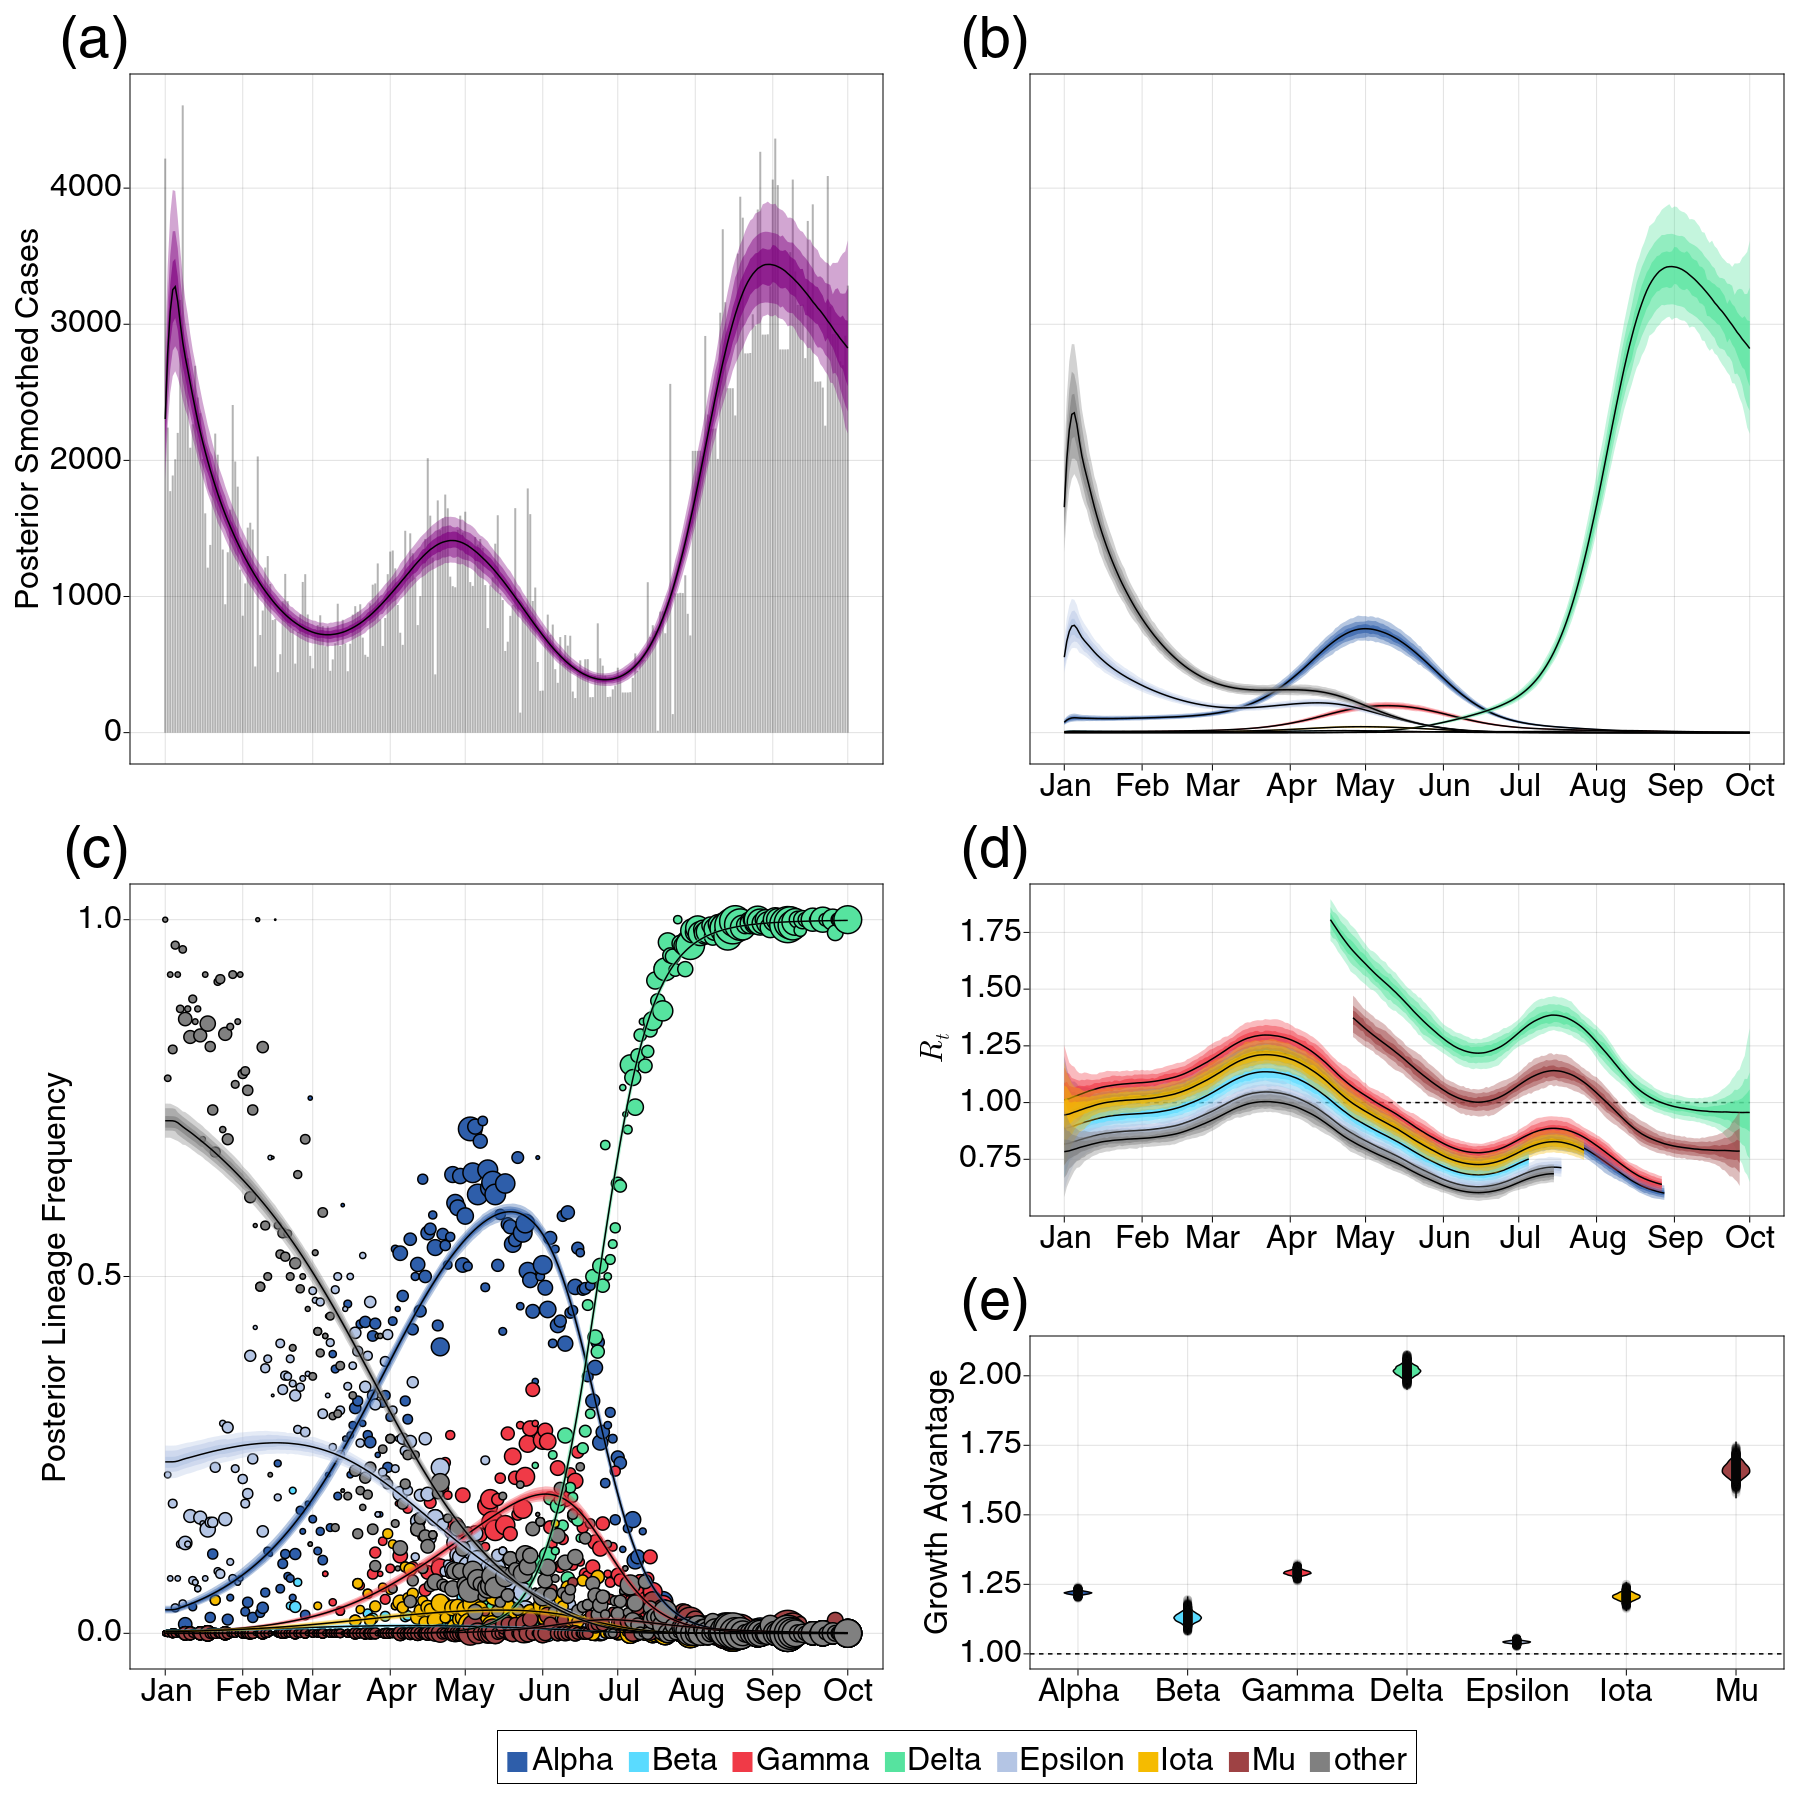

In [53]:
figs[1]

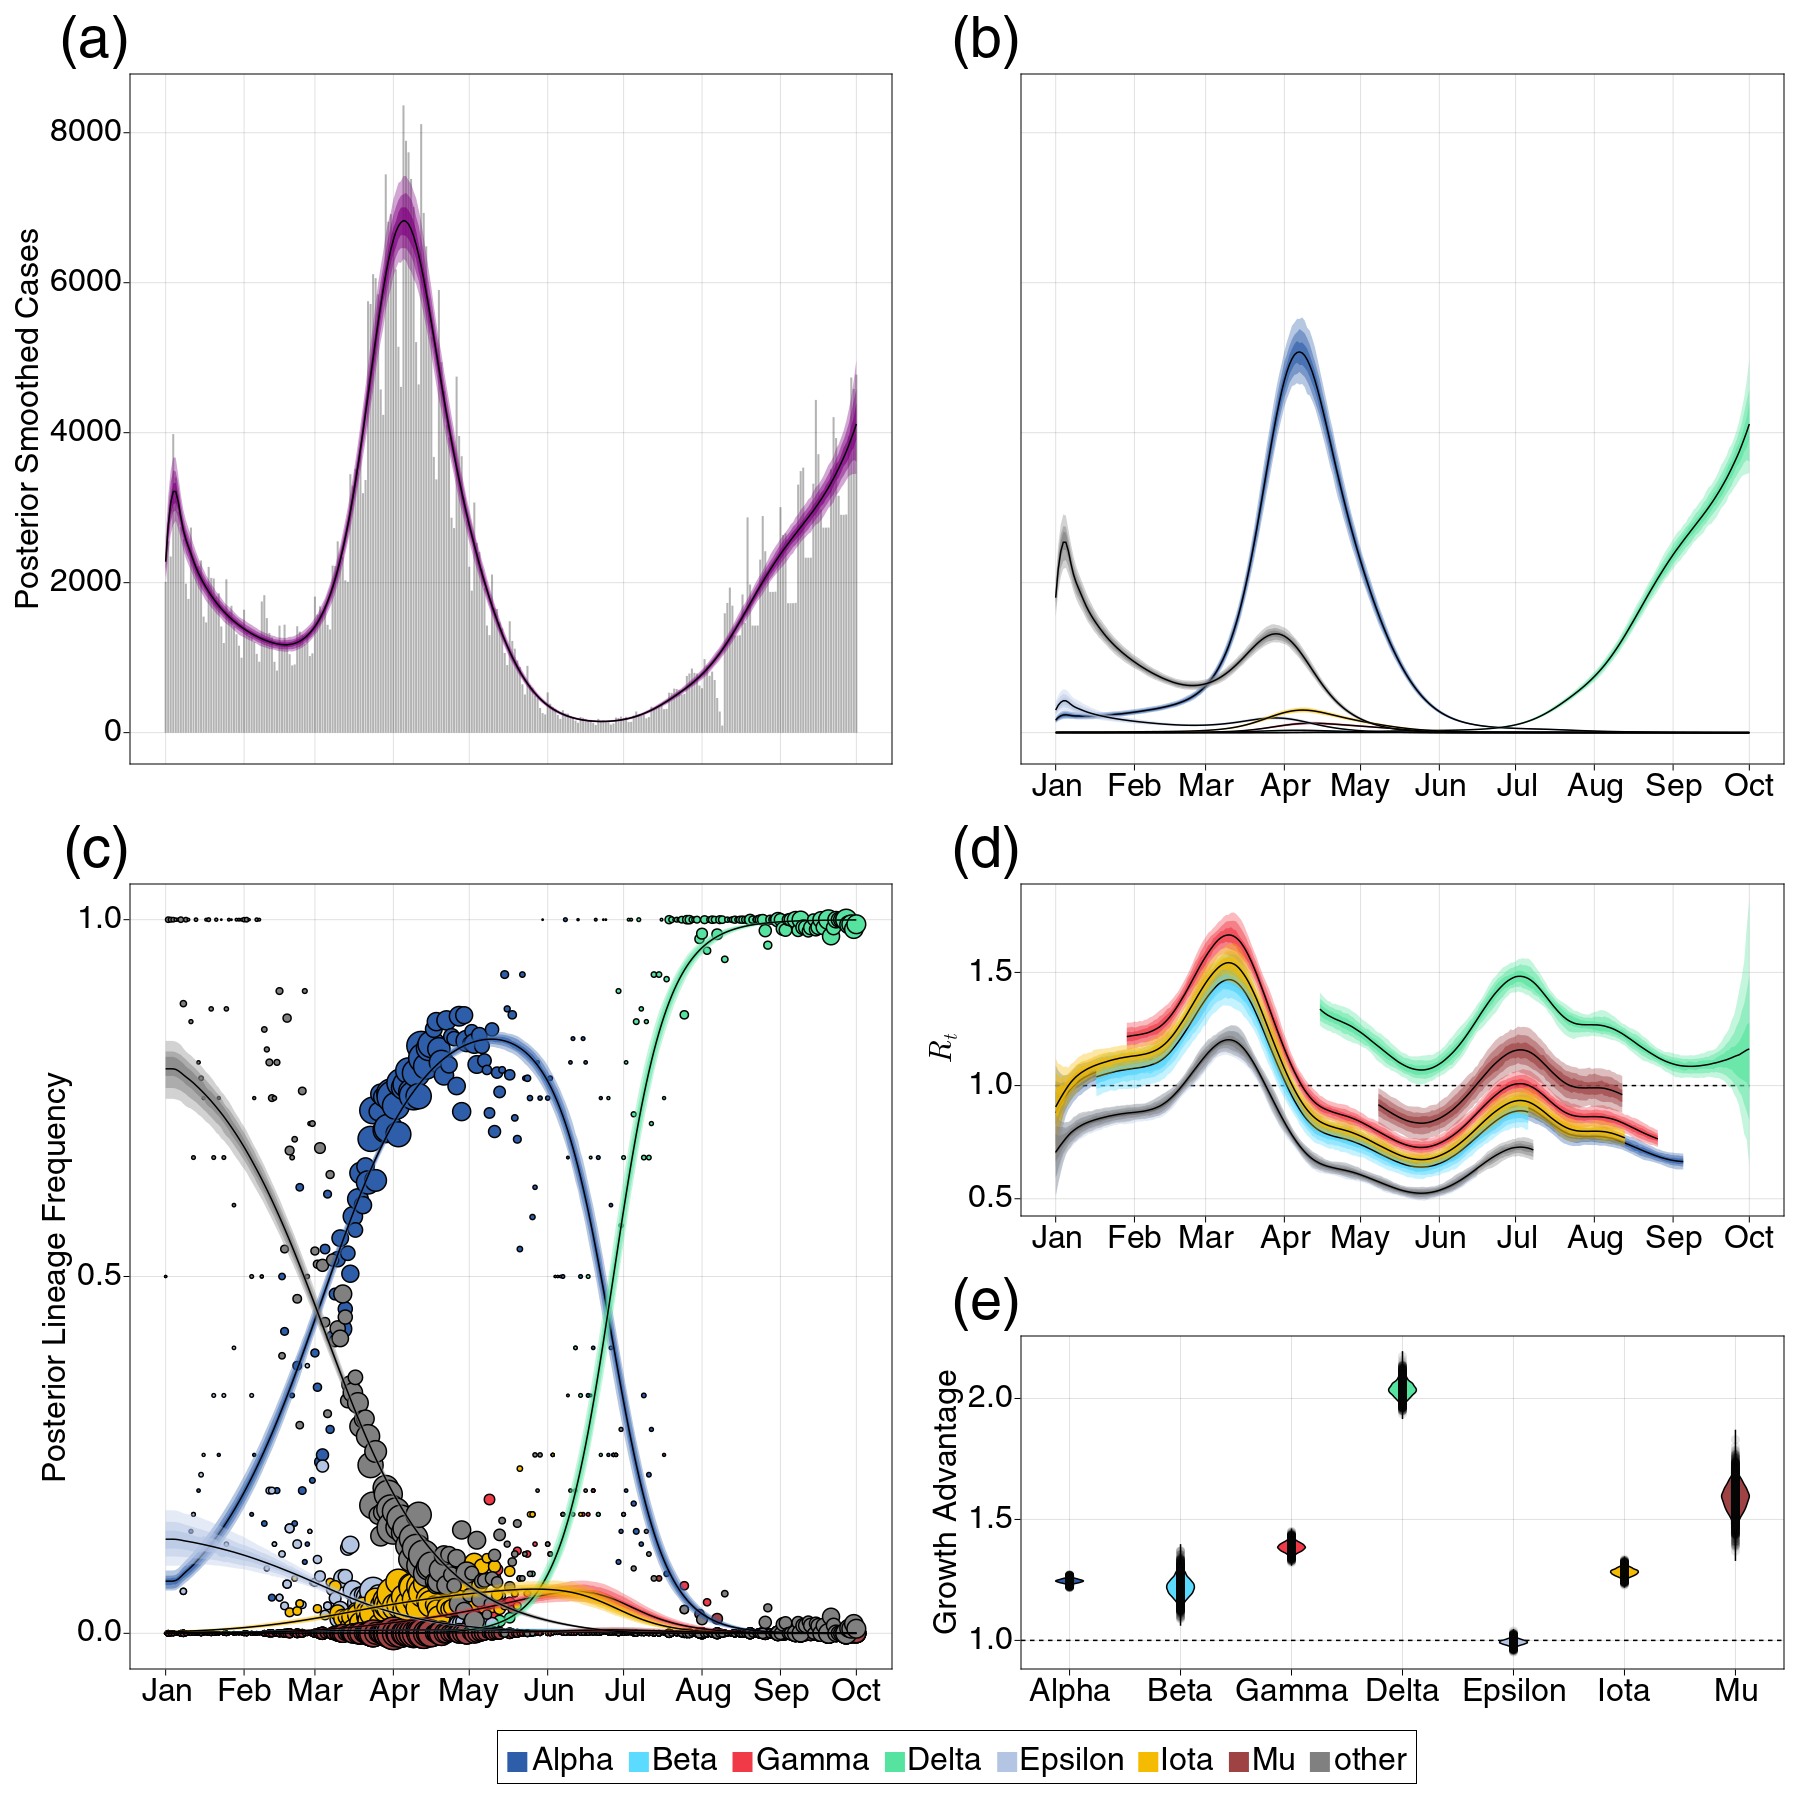

In [54]:
figs[2]

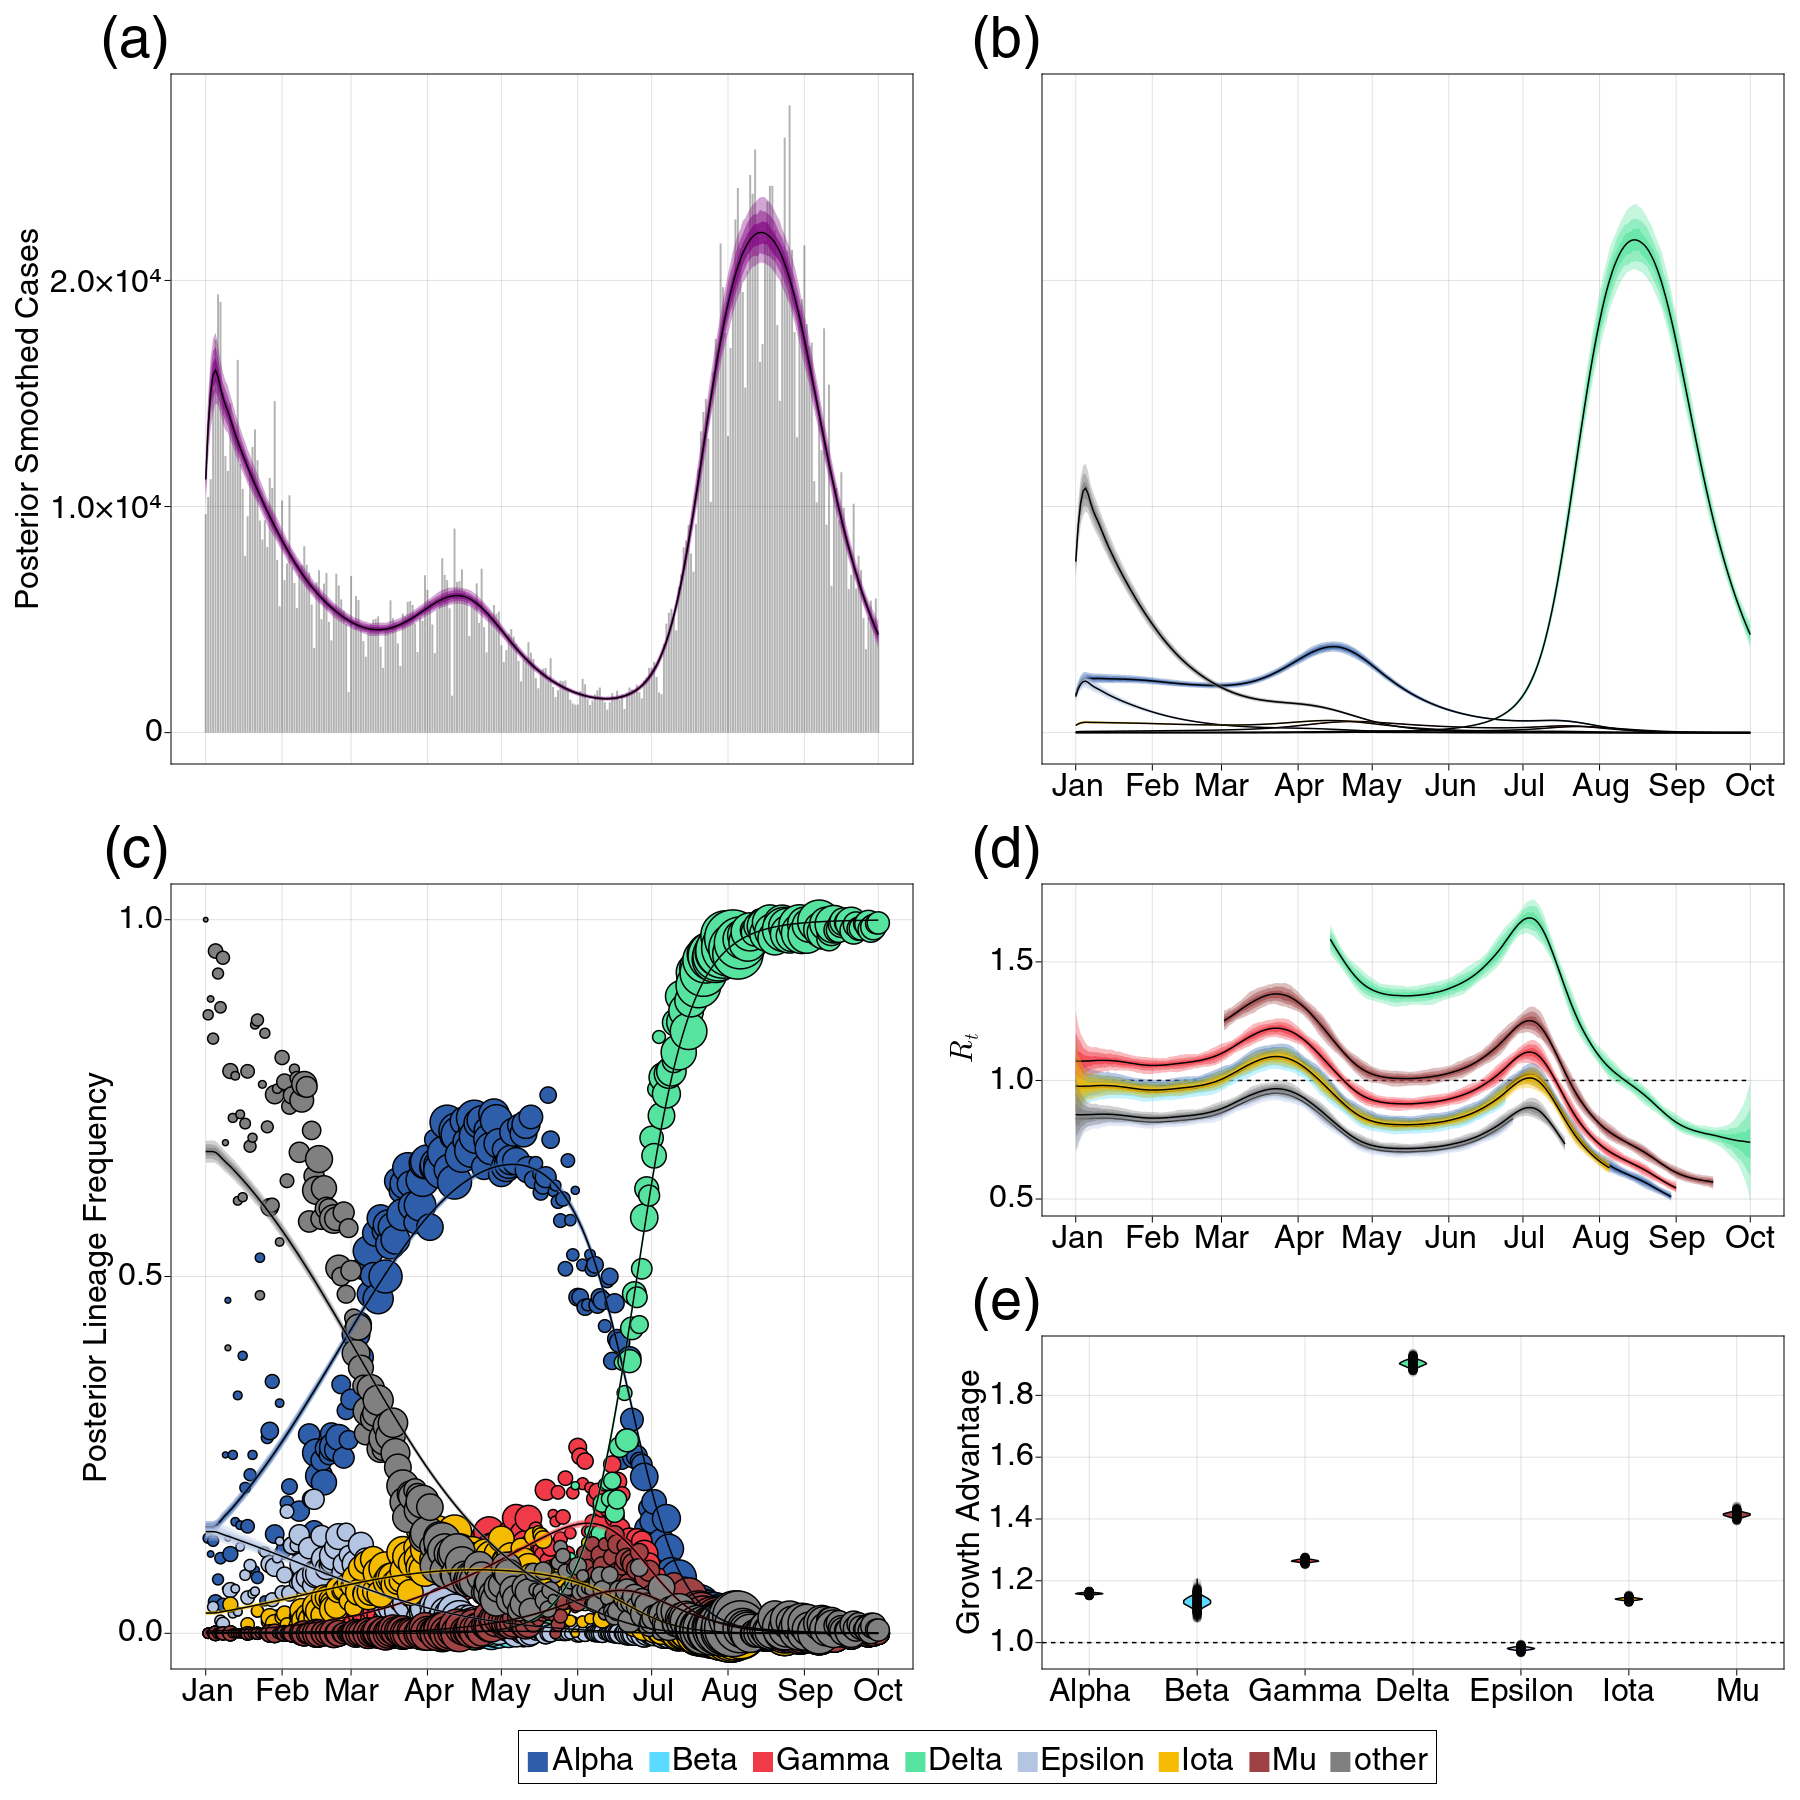

In [55]:
figs[3]

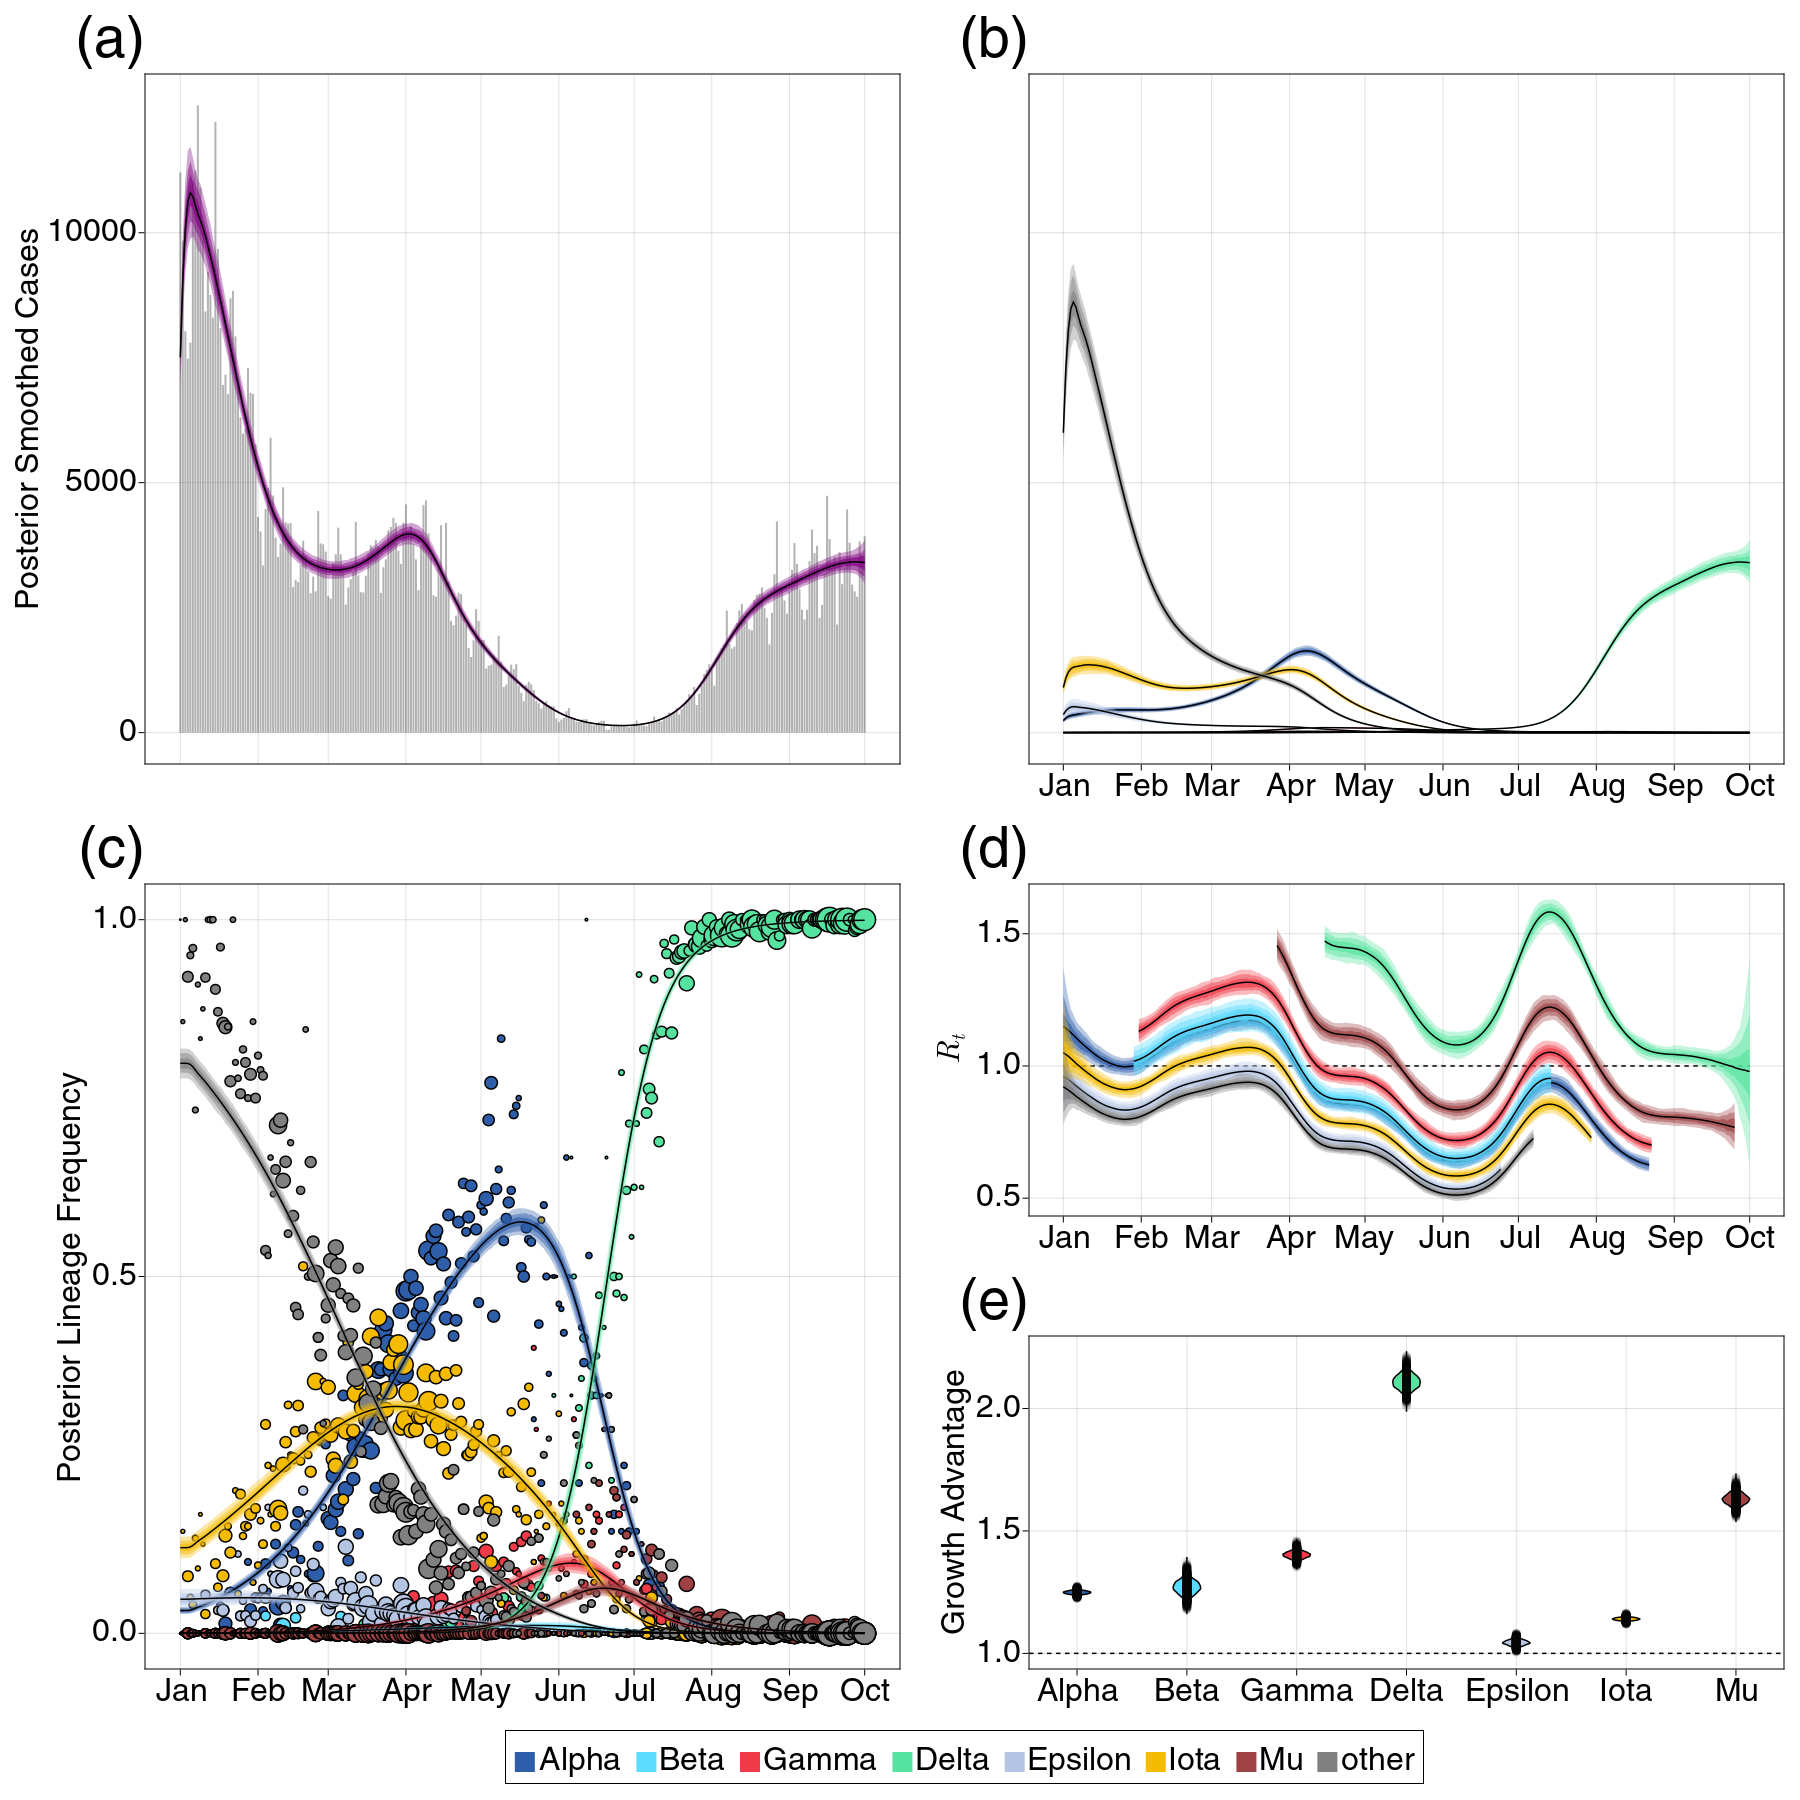

In [56]:
figs[4]

In [61]:
for (i, fig) in enumerate(figs)
    _state = replace(loc_names[i], " " => "_")
    save("../manuscript/figs/fig_2_$(_state).png", fig)
end

## Figure 3: Looking across all states

In [10]:
growth_df = CSV.read("../data/sims/results/inferred_lineage_growth_advantage_all-states-preprint_11_28_21.tsv", DataFrame)

270×9 DataFrame
 Row │ state                      lineage  v_median  v_lower_50  v_upper_50  v ⋯
     │ String                     String   Float64   Float64     Float64     F ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ rt-lineages-Alabama        Alpha    1.12645     1.12112     1.13064     ⋯
   2 │ rt-lineages-Alabama        Beta     0.977862    0.930878    1.02183
   3 │ rt-lineages-Alabama        Gamma    1.21841     1.2061      1.23005
   4 │ rt-lineages-Alabama        Delta    1.662       1.64338     1.67488
   5 │ rt-lineages-Alabama        Epsilon  1.0309      1.01881     1.04609     ⋯
   6 │ rt-lineages-Alabama        Iota     1.10673     1.0943      1.11798
   7 │ rt-lineages-Alabama        Mu       1.24609     1.22662     1.27003
   8 │ rt-lineages-Alaska         Alpha    1.25317     1.24291     1.26299
   9 │ rt-lineages-Alaska         Beta     1.06414     1.01832     1.10651     ⋯
  10 │ rt-lineages-Alaska         Gamma    1.20845     1.1896      1.22449
  11 │ rt-lineages-Alaska         Delta    2.21467     2.17639     2.24925
  ⋮  │             ⋮                 ⋮        ⋮          ⋮           ⋮         ⋱
 261 │ rt-lineages-West_Virginia  Epsilon  0.996793    0.991198    1.00153
 262 │ rt-lineages-West_Virginia  Iota     1.26039     1.25119     1.27002     ⋯
 263 │ rt-lineages-West_Virginia  Mu       1.69924     1.64896     1.73383
 264 │ rt-lineages-Wisconsin      Alpha    1.24358     1.23353     1.25063
 265 │ rt-lineages-Wisconsin      Beta     1.11747     1.09279     1.14453
 266 │ rt-lineages-Wisconsin      Gamma    1.30344     1.28957     1.31746     ⋯
 267 │ rt-lineages-Wisconsin      Delta    1.91969     1.89996     1.94662
 268 │ rt-lineages-Wisconsin      Epsilon  1.06947     1.06059     1.07863
 269 │ rt-lineages-Wisconsin      Iota     1.20452     1.19301     1.21825
 270 │ rt-lineages-Wisconsin      Mu       1.55608     1.52955     1.57565     ⋯
                                                  4 columns and 249 rows omitted

In [11]:
state_names = sort(unique(growth_df.state))
clean_state_names = replace.(state_names, "_" => " ")
clean_state_names = replace.(clean_state_names, "rt-lineages-" => "")

39-element Vector{String}:
 "Alabama"
 "Alaska"
 "Arizona"
 "Arkansas"
 "California"
 "Colorado"
 "Connecticut"
 "Florida"
 "Georgia"
 "Idaho"
 "Illinois"
 "Indiana"
 "Kentucky"
 ⋮
 "Oregon"
 "Pennsylvania"
 "Rhode Island"
 "South Carolina"
 "Tennessee"
 "Texas"
 "Utah"
 "Vermont"
 "Virginia"
 "Washington"
 "West Virginia"
 "Wisconsin"

In [12]:
states_to_ordering(state) = findfirst(s -> s==state, state_names)

states_to_ordering (generic function with 1 method)

In [13]:
function rt_from_frequency_dynamics.get_sequence_map(seq_labels)
    lineage_map = Dict()
    for (i, lineage) in enumerate(seq_labels)
        lineage_map[lineage] = i
    end
    return lineage_map
end

In [14]:
function make_figure_3(growth_df, colors)
    fig = Figure(backgroundcolor = RGBf0(1., 1., 1.), resolution = (2400, 2000), fontsize = 36, font = "Helvetica")
    g_growth_all = fig[1:3, 1] = GridLayout()
    ax_growth_all = Axis(g_growth_all[1,1],xlabel = "Inferred Growth Advantage")
    
    # Redefine seq_labels with unique names in the thingy?
    seq_labels = unique(growth_df.lineage)
    lineage_map = get_sequence_map(seq_labels)

    # Start Plot
    vlines!(ax_growth_all, [1.], color = :black, linewidth = 2.5, linestyle = :dash)
    for (lineage, name) in enumerate(seq_labels[1:end-1])
        this_color = colors[lineage_map[name]]
        this_lineage = filter(row -> row.lineage == name, growth_df)
    
        # Plot 80_CI
        rangebars!(ax_growth_all, 
            states_to_ordering.(this_lineage.state), 
            this_lineage.v_lower_80, 
            this_lineage.v_upper_80,
            direction = :x, 
            color = (this_color, 1.0),
            linewidth = 4)
    
        # Plot 50_CI
        rangebars!(ax_growth_all, 
            states_to_ordering.(this_lineage.state), 
            this_lineage.v_lower_50, 
            this_lineage.v_upper_50,
            direction = :x,
            color = (this_color, 1.0),
            linewidth = 6)
    end

    for (lineage, name) in enumerate(seq_labels[1:end-1])
        this_color = colors[lineage_map[name]]
        this_lineage = filter(row -> row.lineage == name, growth_df)
    
        # Plot median
        scatter!(ax_growth_all, 
            this_lineage.v_median, 
            states_to_ordering.(this_lineage.state), 
            color = this_color,
            strokewidth = 3.5,
            markersize = 18.)
    end

    ax_growth_all.xticks = 0:0.5:3
    ax_growth_all.yticks = 1:length(state_names)
    ax_growth_all.ytickformat = ys -> clean_state_names[convert.(Int,ys)]
    ax_growth_all.yreversed = true

    # Growth Advantage medians
    g_growth_meds = fig[1, 2] = GridLayout()
    ax_growth_meds = Axis(g_growth_meds[1,1],ylabel = "Median Growth Advantage")

    hlines!(ax_growth_meds, [1.], color = :black, linewidth = 2.5, linestyle = :dash)
    lineage_nums = [lineage_map[lin] for lin in growth_df.lineage]
    lineage_cols = [colors[lin] for lin in lineage_nums]

    violin!(ax_growth_meds, lineage_nums, growth_df.v_median, 
        datalimits = extrema, 
        color = lineage_cols,
        orientation = :horizontal,
        strokewidth = 1.5)

    scatter!(ax_growth_meds, lineage_nums, growth_df.v_median, 
        color = lineage_cols,
        strokewidth = 2.5)

    ax_growth_meds.xticks = 1:length(seq_labels)
    ax_growth_meds.xtickformat = xs -> seq_labels[convert.(Int,xs)]

    # Adding legend
    elements = [PolyElement(polycolor = colors[l]) for (l, s) in enumerate(seq_labels)]
    fig[2,2] = Legend(fig, elements, seq_labels, "", orientation = :horizontal, tellwidth = false, tellheight = true)

    for (label, layout) in zip(["(a)", "(b)"], [g_growth_all, g_growth_meds])
    Label(layout[1, 1, TopLeft()], label,
        textsize = 60,
        padding = (0, 5, 5, 0),
        font = "Helvetica Bold",
        halign = :right)
    end
    fig 
end

make_figure_3 (generic function with 1 method)

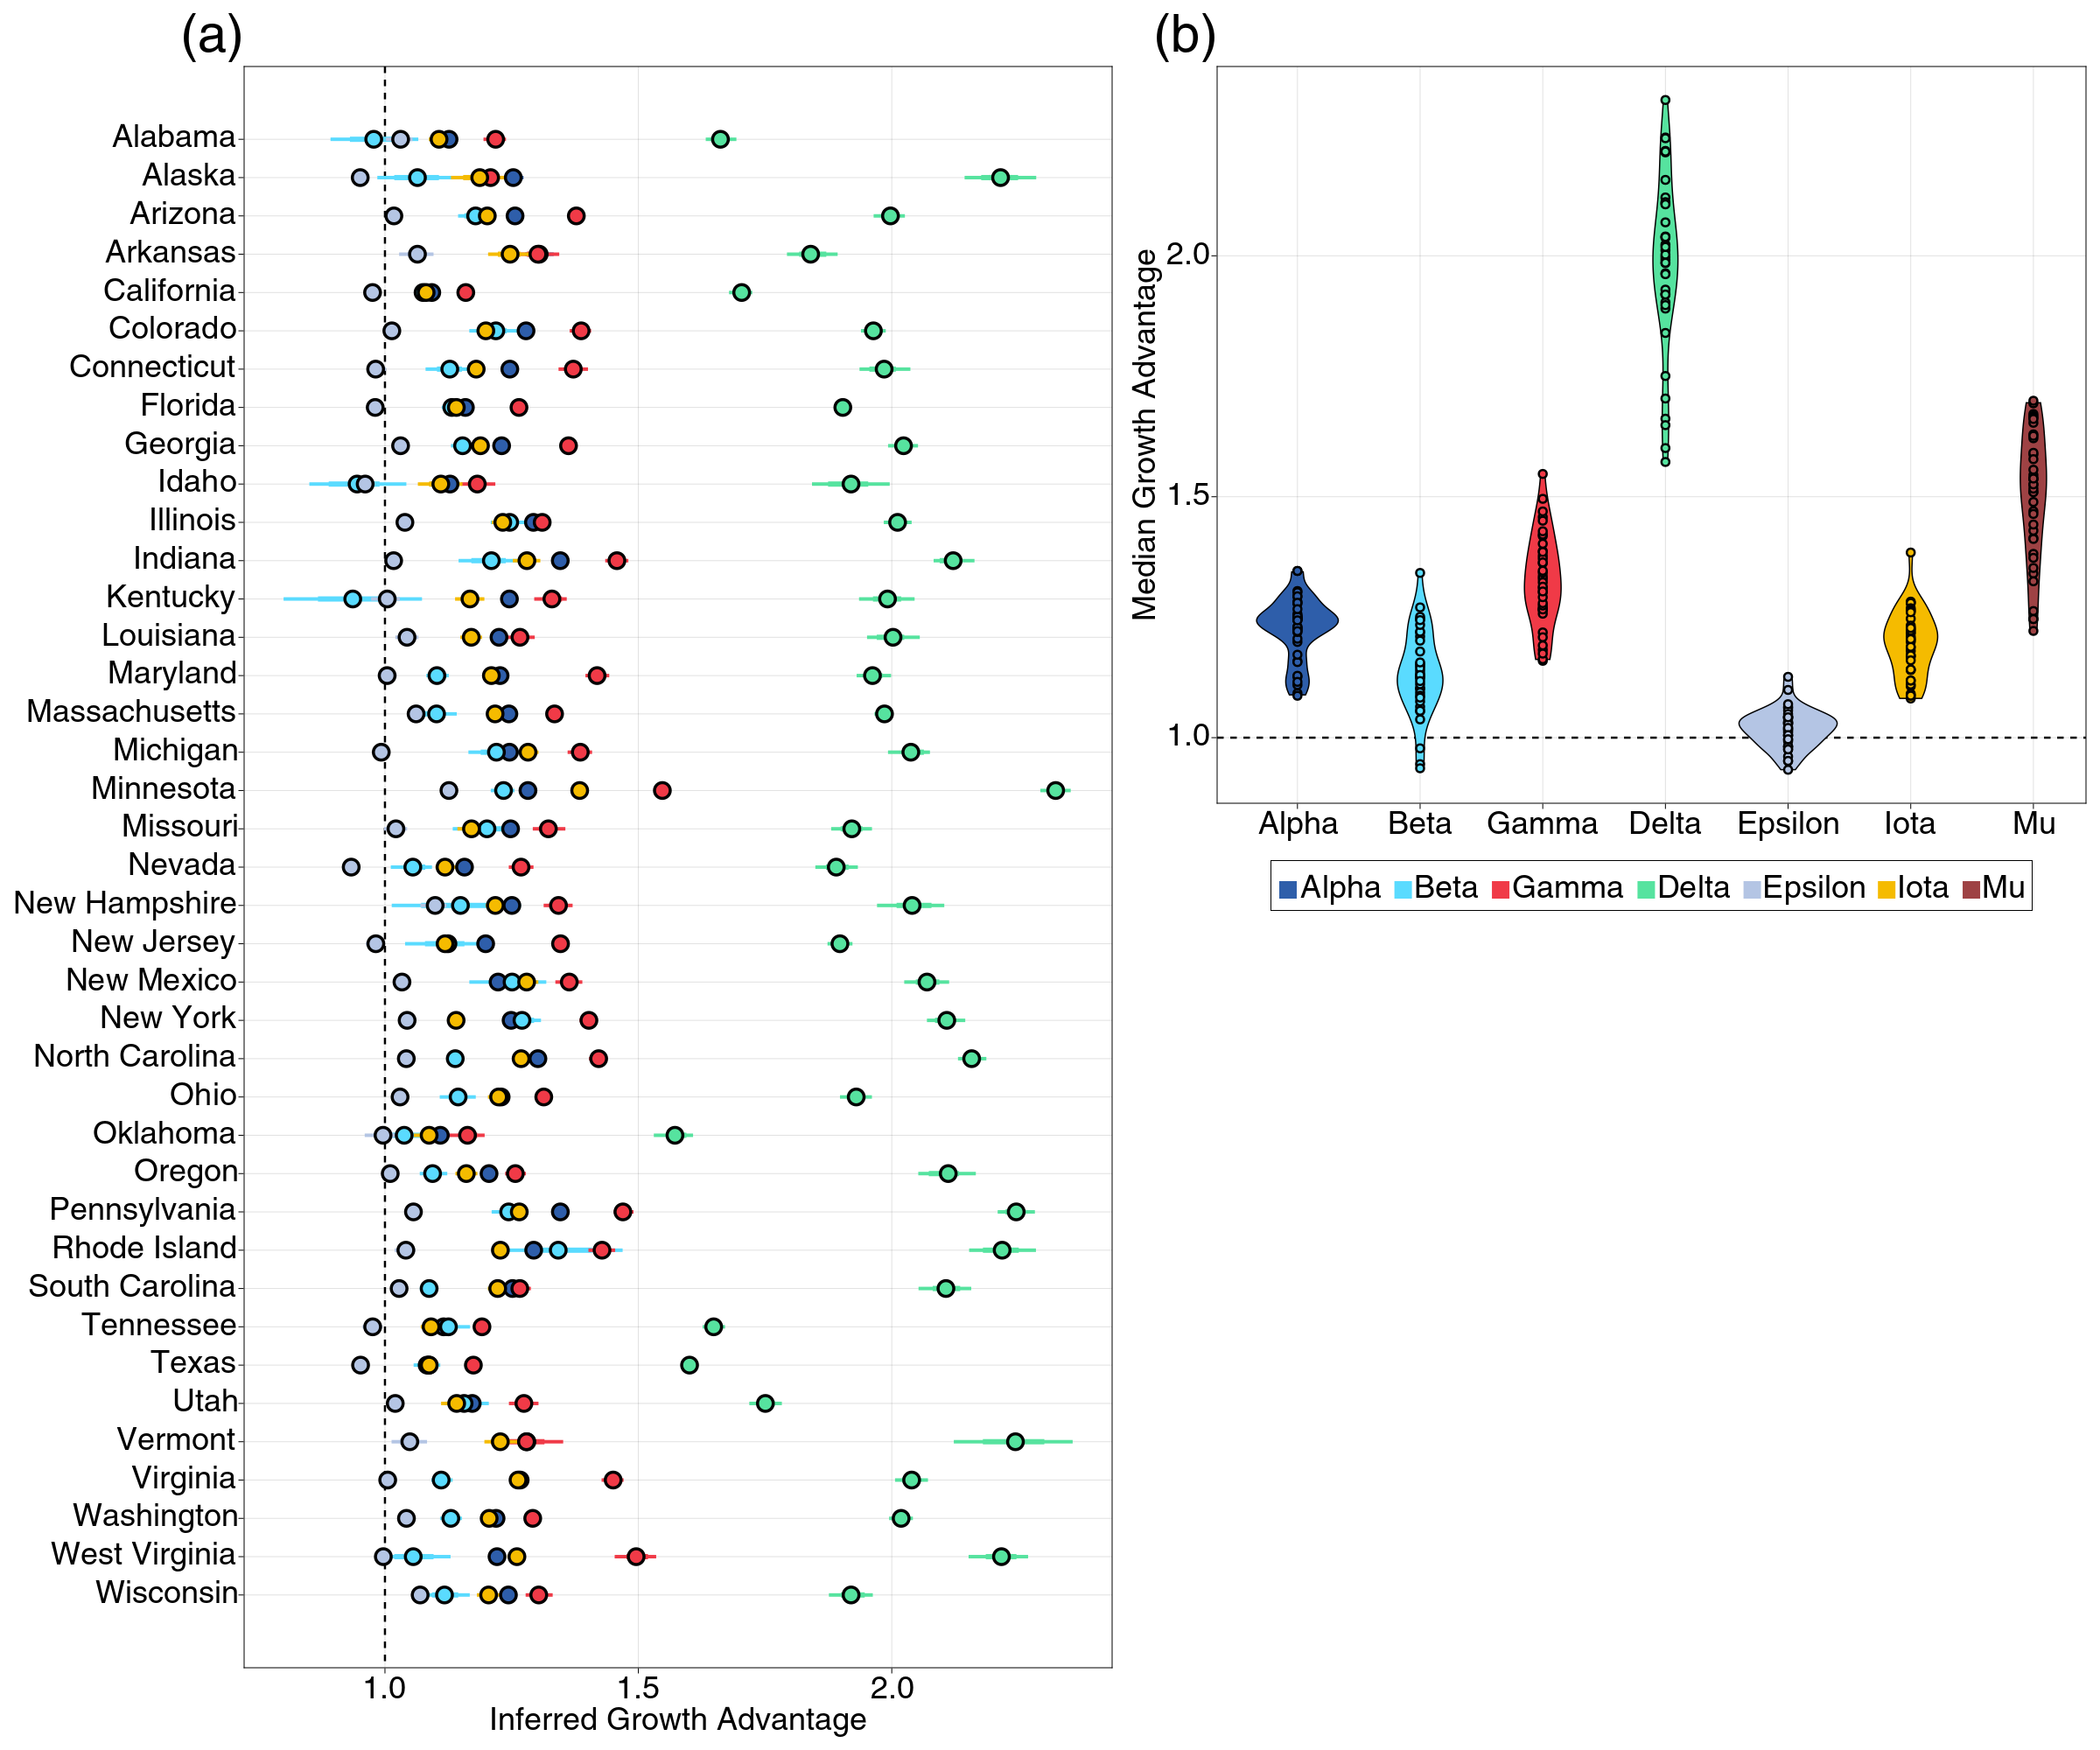

In [15]:
fig_3 = make_figure_3(growth_df, colors_variant)
fig_3

In [20]:
save("../manuscript/figs/fig_3_growth_advantages.png", fig_3)

CairoScreen{Cairo.CairoSurfaceBase{UInt32}} with surface:
Cairo.CairoSurfaceBase{UInt32}(Ptr{Nothing} @0x00007fad731284a0, 2400.0, 2000.0)


## Figure 5: Vaccination Histograms

In [26]:
vaccination_effects = CSV.read("../data/sims/results/vaccination-effects_11_28_21.tsv", DataFrame)

304×4 DataFrame
 Row │ state          lineage  effect             estimate  
     │ String         String   String             Float64   
─────┼──────────────────────────────────────────────────────
   1 │ Alabama        other    vaccination_slope  -0.230413
   2 │ Alabama        Alpha    vaccination_slope  -0.347473
   3 │ Alabama        Beta     vaccination_slope  -0.303964
   4 │ Alabama        Delta    vaccination_slope  -0.655358
   5 │ Alabama        Epsilon  vaccination_slope  -0.283525
   6 │ Alabama        Gamma    vaccination_slope  -0.368557
   7 │ Alabama        Iota     vaccination_slope  -0.273907
   8 │ Alabama        Mu       vaccination_slope  -0.39363
   9 │ Alaska         other    vaccination_slope  -0.541443
  10 │ Alaska         Alpha    vaccination_slope  -0.658503
  11 │ Alaska         Beta     vaccination_slope  -0.614994
  ⋮  │       ⋮           ⋮             ⋮              ⋮
 295 │ West Virginia  Iota     vaccination_slope  -0.534063
 296 │ West Virginia  Mu       vaccination_slope  -0.653786
 297 │ Wisconsin      other    vaccination_slope  -0.347471
 298 │ Wisconsin      Alpha    vaccination_slope  -0.464531
 299 │ Wisconsin      Beta     vaccination_slope  -0.421022
 300 │ Wisconsin      Delta    vaccination_slope  -0.772416
 301 │ Wisconsin      Epsilon  vaccination_slope  -0.400583
 302 │ Wisconsin      Gamma    vaccination_slope  -0.485615
 303 │ Wisconsin      Iota     vaccination_slope  -0.390965
 304 │ Wisconsin      Mu       vaccination_slope  -0.510687
                                            283 rows omitted

In [54]:
function make_figure_5(vacc, n_rows, colors)
    lineages = unique(vacc.lineage)
    N_lineage = length(lineages)
    
    seq_labels = lineages
    if "other" in seq_labels
        #seq_labels = seq_labels
        is_not_other = [(s != "other") for s in seq_labels]
        seq_labels = seq_labels[is_not_other]
        push!(seq_labels, "other")
    end
    lineage_map = get_sequence_map(seq_labels)
    
    # Initalize Number of Rows
    n_cols = div(N_lineage, n_rows)
    this_row = 1
    
    g_list = []
    ax_list = []
    fig = Figure(backgroundcolor = RGBf0(1., 1., 1.), resolution = (2000, 1000), fontsize = 36, font = "Helvetica")
    for (lineage, name) in enumerate(seq_labels)
        this_col = mod(lineage-1, n_cols) + 1
        
        g = fig[this_row, this_col] = GridLayout()
        ax = Axis(g[1,1]) 
        
        push!(g_list, g)
        push!(ax_list, ax)
        
        # Add dashed line
        vlines!(ax, [0.0], linestyle = :dash, color = :black, linewidth = 5.0)
        
        # Filter to lineage of interest
        lineage_df = filter(row -> row.lineage == name, vacc)    
        this_color = colors[lineage_map[name]]
        
        hist!(ax, lineage_df.estimate, color = this_color, normalization = :pdf)
        
        if this_row != n_rows
            hidexdecorations!(ax, grid = false)
        end
        
        if this_col != 1
            hideydecorations!(ax, grid = false) 
        end
         # If at the end of the row, add new one
        if mod(lineage, div(N_lineage, n_rows)) == 0
           this_row += 1 
        end
    end
    
    linkxaxes!(ax_list...)
    linkyaxes!(ax_list...)
    elements = [PolyElement(polycolor = colors[l]) for (l,s) in enumerate(seq_labels)]
    fig[n_rows+1,1:n_cols] = Legend(fig, elements, seq_labels, "", orientation = :horizontal, tellwidth = false, tellheight = true)
    fig
end

# xaxis, indicating which variant/lineage in each panel, legend

make_figure_5 (generic function with 1 method)

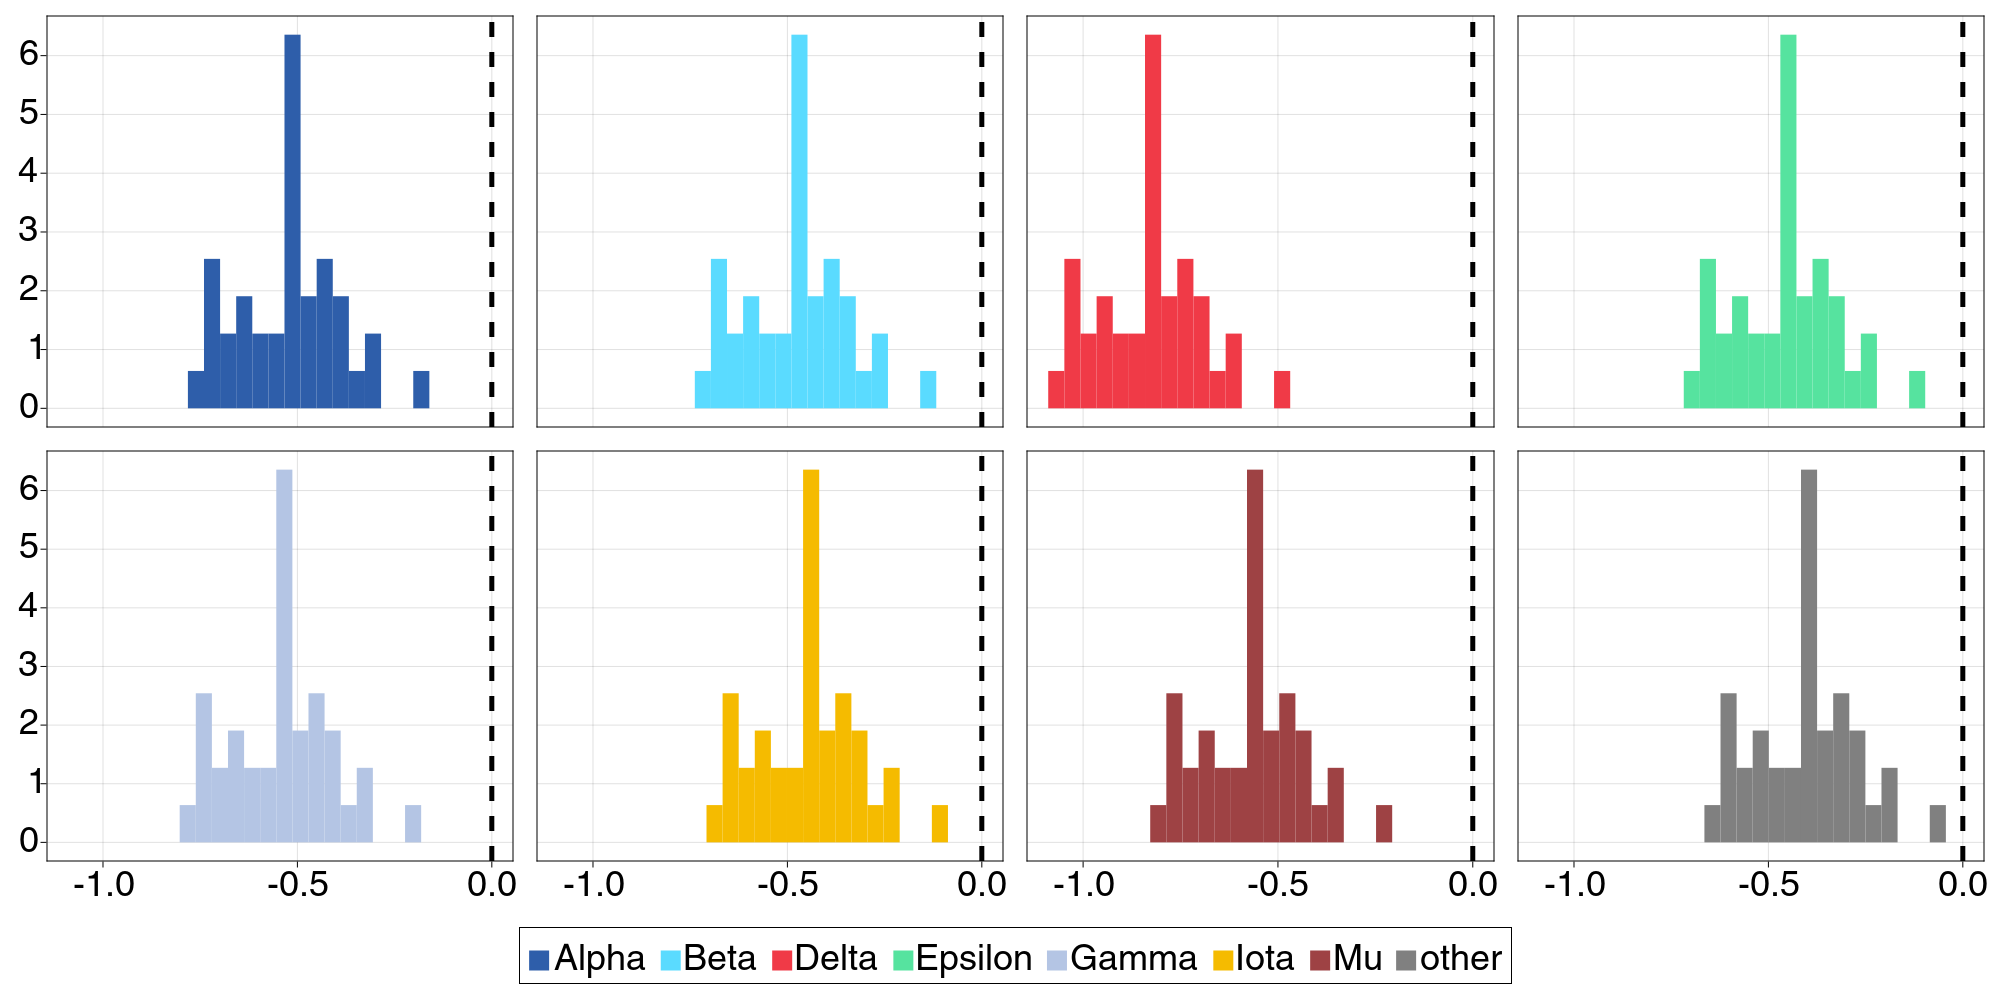

In [55]:
fig_5 = make_figure_5(vaccination_effects, 2, colors_variant)
fig_5

In [56]:
save("../manuscript/figs/fig_5_vaccination_effect.png",fig_5)

CairoScreen{Cairo.CairoSurfaceBase{UInt32}} with surface:
Cairo.CairoSurfaceBase{UInt32}(Ptr{Nothing} @0x00007fad6381d800, 2000.0, 1000.0)


## Figure 4: Consensus in Rt

In [16]:
rt_df = CSV.read("../data/sims/results/inferred_lineage_rts_all-states-preprint_11_28_21.tsv", DataFrame)
filter!(row -> row.state != "rt-lineages-California", rt_df)
first(rt_df, 10)

10×11 DataFrame
 Row │ state                date        lineage  rt_median  rt_lower_50  rt_up ⋯
     │ String               Date        String   Float64    Float64      Float ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ rt-lineages-Alabama  2021-01-02  Alpha     0.761467     0.67616      0. ⋯
   2 │ rt-lineages-Alabama  2021-01-03  Alpha     0.783782     0.718665     0.
   3 │ rt-lineages-Alabama  2021-01-04  Alpha     0.805195     0.740203     0.
   4 │ rt-lineages-Alabama  2021-01-05  Alpha     0.825436     0.763298     0.
   5 │ rt-lineages-Alabama  2021-01-06  Alpha     0.844182     0.784756     0. ⋯
   6 │ rt-lineages-Alabama  2021-01-07  Alpha     0.862702     0.815027     0.
   7 │ rt-lineages-Alabama  2021-01-08  Alpha     0.878791     0.823448     0.
   8 │ rt-lineages-Alabama  2021-01-09  Alpha     0.892229     0.846958     0.
   9 │ rt-lineages-Alabama  2021-01-10  Alpha     0.902237     0.86449      0. ⋯
  10 │ rt-lineages-Alabama  2021-01-11  Alpha     0.909376     0.870163     0.
                                                               6 columns omitted

In [ ]:
rt_

In [17]:
function find_date_idx(dates, unique_dates)
    return [findfirst(x -> x == day, unique_dates) for day in dates]
end

find_date_idx (generic function with 1 method)

In [23]:
function make_figure_4(rt, n_rows, colors)    
    unique_dates = sort(unique(rt.date))
    lineages = unique(rt.lineage)
    N_lineage = length(lineages)
    
    seq_labels = lineages
    lineage_map = get_sequence_map(seq_labels)
    
    # Initalize Number of Rows
    n_cols = div(N_lineage, n_rows)
    this_row = 1

    fig = Figure(backgroundcolor = RGBf0(1., 1., 1.), resolution = (2400, 1200), fontsize = 36, font = "Helvetica")
    g_list = []
    ax_list = []
    for (lineage, name) in enumerate(lineages)
        this_col = mod(lineage-1, n_cols) + 1
        
        g = fig[this_row, this_col] = GridLayout()
        ax = Axis(g[1,1]) 
        
        push!(g_list, g)
        push!(ax_list, ax)
        
        # Add dashed line
        hlines!(ax, [1.0], linestyle = :dash, color = :black)
        
        # Filter to lineage of interest
        lineage_df = filter(row -> row.lineage == name, rt)
        this_color = colors[lineage_map[name]]
        
        # Plot each state independently
        for state_df in groupby(lineage_df, :state)
            date_num = find_date_idx(state_df.date, unique_dates)
            idx_freq = (state_df.freq_median .> 0.001)
            if any(idx_freq)
                band!(ax, date_num[idx_freq], state_df.rt_lower_80[idx_freq], state_df.rt_upper_80[idx_freq], color = (this_color, alphas[2]))
                band!(ax, date_num[idx_freq], state_df.rt_lower_50[idx_freq], state_df.rt_upper_50[idx_freq], color = (this_color, alphas[1]))
                lines!(ax, date_num[idx_freq], state_df.rt_median[idx_freq], color = :black)
            end
       end
        
        # If this is the last row
        if this_row == n_rows
            ticks, _ = get_nice_ticks(unique_dates)
            ax.xticks = ticks[1:2:end]
            ax.xtickformat = xs -> Dates.monthabbr.(unique_dates[convert.(Int, xs)])
        else 
            hidexdecorations!(ax, grid = false)
        end
        
        ax.yticks = 0:0.5:3.
        ylims!(ax, 0, nothing)
        
        if this_col != 1
           hideydecorations!(ax, grid = false) 
        end
        
        # If at the end of the row, add new one
        if mod(lineage, div(N_lineage, n_rows)) == 0
           this_row += 1 
        end
    end 
    
    linkxaxes!(ax_list...)
    linkyaxes!(ax_list...)
    
    elements = [PolyElement(polycolor = colors[lineage_map[l]]) for l in seq_labels]
    fig[n_rows+1,1:n_cols] = Legend(fig, elements, seq_labels, "", 
        orientation = :horizontal, tellwidth = false, tellheight = true, fontsize=60)

    fig
end

make_figure_4 (generic function with 1 method)

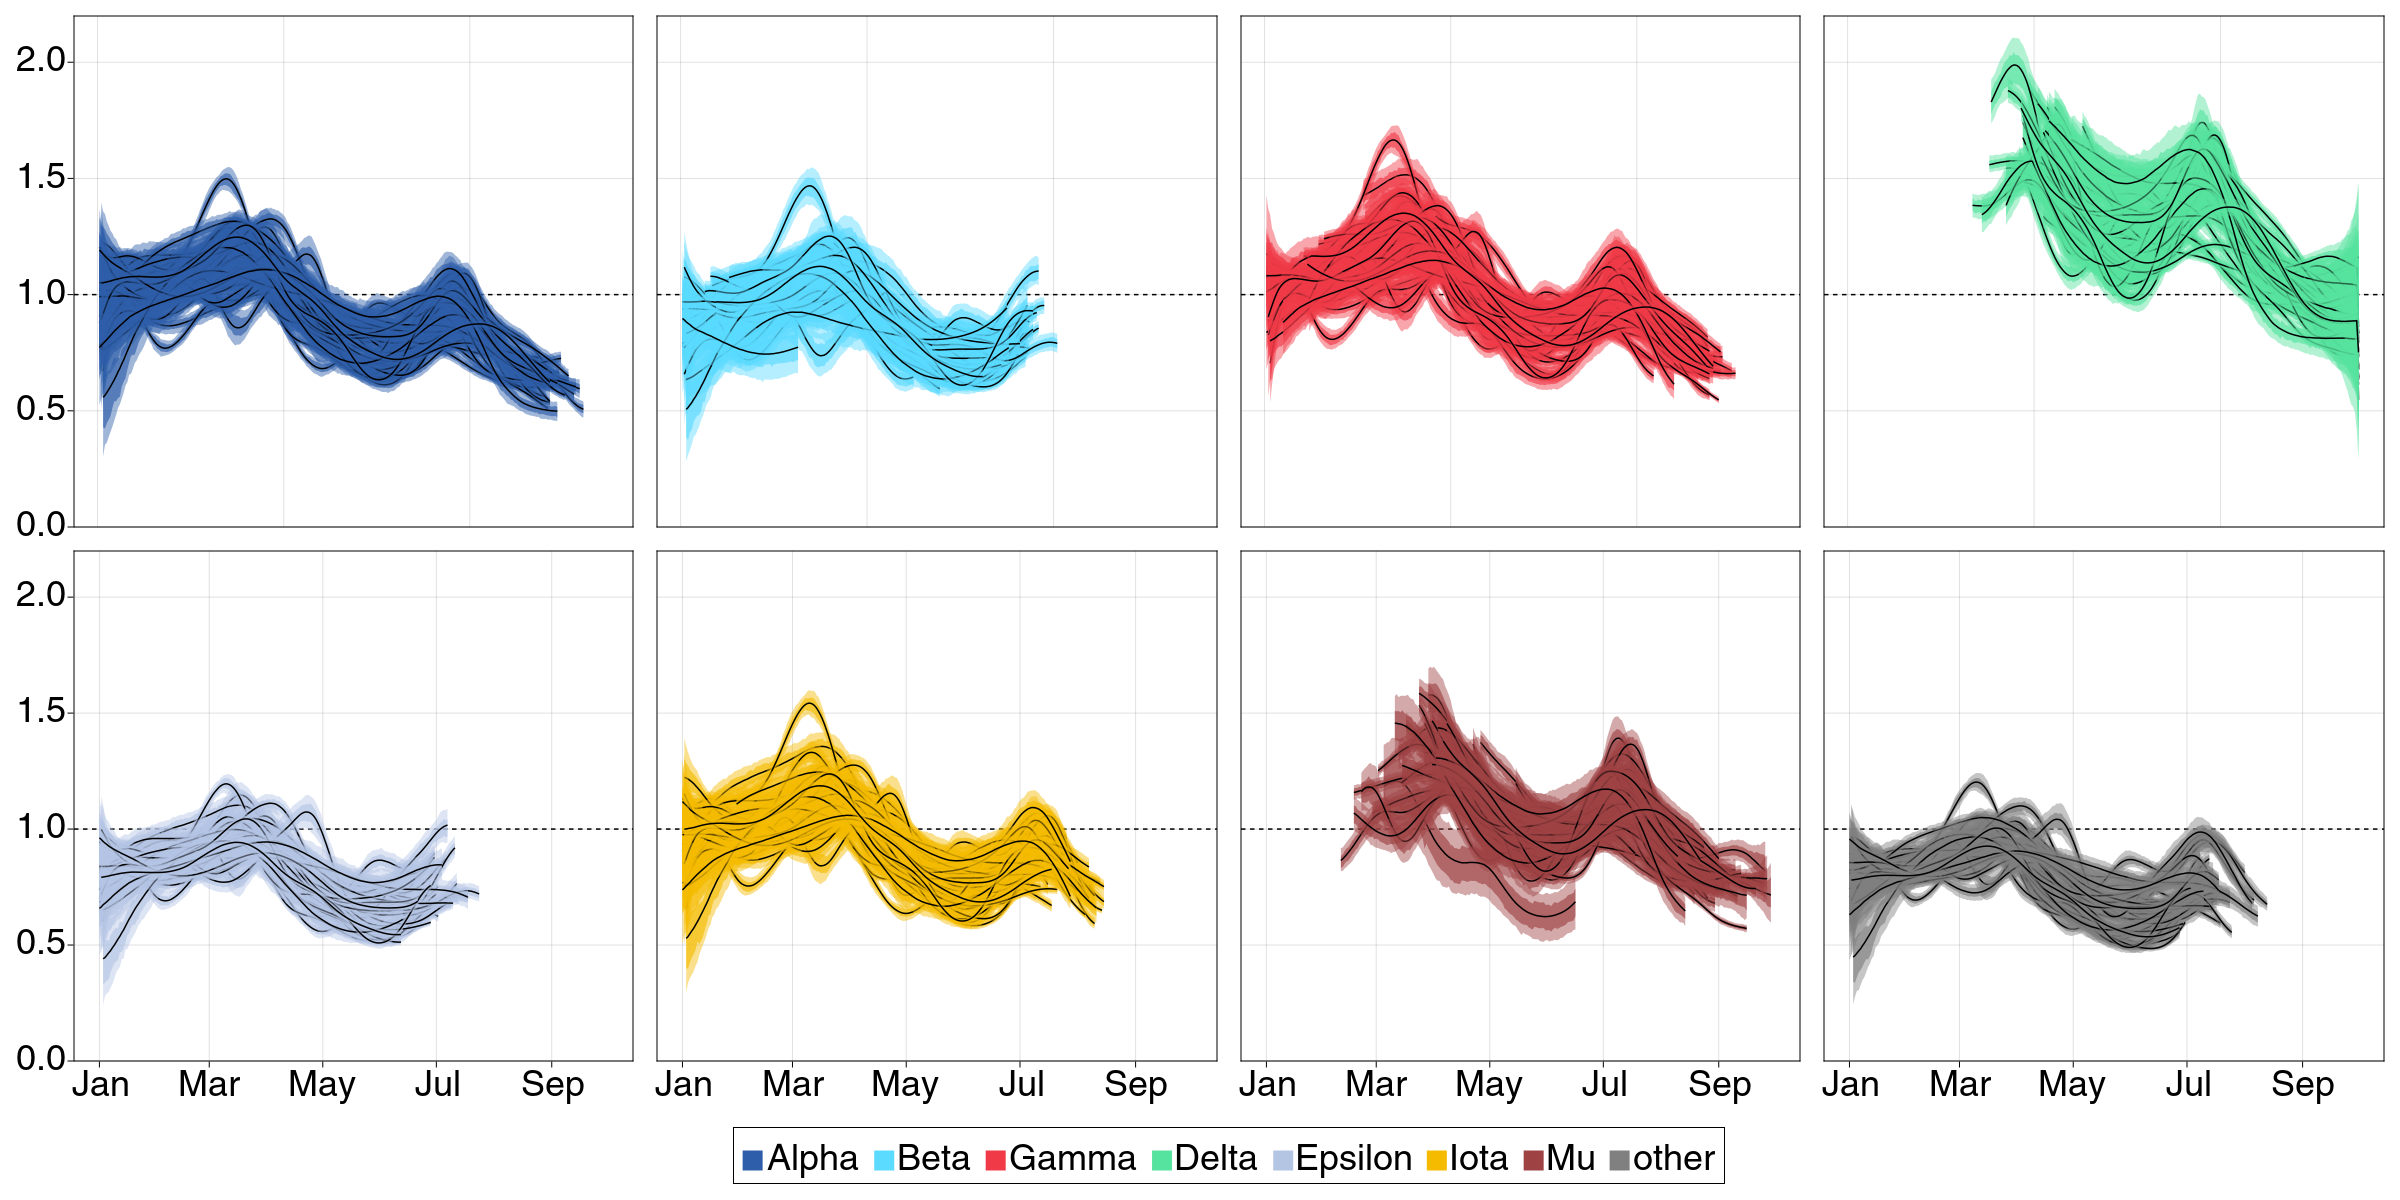

In [24]:
fig_4 = make_figure_4(rt_df, 2, colors_variant)
fig_4

In [25]:
save("../manuscript/figs/fig_4_rt_consensus.png",fig_4)

CairoScreen{Cairo.CairoSurfaceBase{UInt32}} with surface:
Cairo.CairoSurfaceBase{UInt32}(Ptr{Nothing} @0x00007fad731133c0, 2400.0, 1200.0)
